In [21]:
import numpy as np
import time
import matplotlib.pyplot as plt

import jax.numpy as jnp
from jax.nn import sigmoid
from jax.nn.initializers import glorot_normal, normal

from functools import partial
from jax import lax, random, value_and_grad, jit
from jax.experimental.stax import Dense, Relu
from jax.experimental import stax, optimizers

In [55]:
def generate_ou_process(x0, mu, sigma, dt, t_end, rng, sigma_noise, batch_size=None):
    n_steps = int(np.ceil(t_end / dt))
    t_vals = dt * np.arange(n_steps)
    if batch_size is None:
        steps = rng.normal(loc=dt*mu, scale=np.sqrt(dt)*sigma, size=(n_steps,))
        steps[0] = x0
        process_vals = np.cumsum(steps)
    else:
        steps = rng.normal(loc=dt*mu, scale=np.sqrt(dt)*sigma, size=(batch_size, n_steps))
        steps[:, 0] = x0
        process_vals = np.cumsum(steps, axis=1)
        
    noisy_process = process_vals + rng.normal(loc=0.0, scale=sigma_noise, size=process_vals.shape)
    
    return t_vals, process_vals, noisy_process

In [56]:
rng = np.random.RandomState(123)

t_vals, process_vals, noisy_process_vals = \
    generate_ou_process(x0=0.0, mu=0.1, sigma=0.5, dt=0.1, t_end=100, rng=rng, sigma_noise=0.5, batch_size=4)

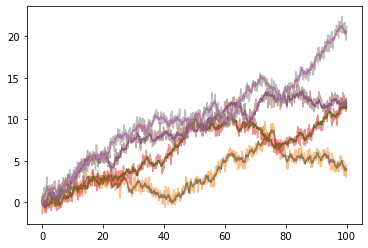

In [58]:
for i in range(4):
    plt.plot(t_vals, process_vals[i, :])
    plt.plot(t_vals, noisy_process_vals[i, :], alpha=0.5)

In [5]:
def GRU(out_dim, W_init=glorot_normal(), b_init=normal()):
    def init_fun(rng, input_shape):
        """Initializer a GRU layer for stax"""
        hidden = b_init(rng, (input_shape[0], out_dim))
        
        k1, k2, k3 = random.split(rng, num=3)
        update_W, update_U, update_b = (
            W_init(k1, (input_shape[2], out_dim)),
            W_init(k2, (out_dim, out_dim)),
            b_init(k3, (out_dim,)),
        )
        
        k1, k2, k3 = random.split(rng, num=3)
        reset_W, reset_U, reset_b = (
            W_init(k1, (input_shape[2], out_dim)),
            W_init(k2, (out_dim, out_dim)),
            b_init(k3, (out_dim,)),
        )
        
        k1, k2, k3 = random.split(rng, num=3)
        out_W, out_U, out_b = (
            W_init(k1, (input_shape[2], out_dim)),
            W_init(k2, (out_dim, out_dim)),
            b_init(k3, (out_dim,)),
        )
        
        # Input dim 0 is the batch dimension
        # Input dim 1 is the time dimension
        output_shape = (input_shape[0], input_shape[1], out_dim)
        return (output_shape,
                (hidden,
                 (update_W, update_U, update_b),
                 (reset_W, reset_U, reset_b),
                 (out_W, out_U, out_b)
                )
        )
    
    def apply_fun(params, inputs, **kwargs):
        """Loop over all the time steps of an input sequence."""
        h = params[0]
        
        def apply_fun_scan(params, hidden, inp):
            _, (update_W, update_U, update_b), (reset_W, reset_U, reset_b),\
                (out_W, out_U, out_b) = params
            
            update_gate = sigmoid(jnp.dot(inp, update_W) + jnp.dot(hidden, update_U) + update_b)
            reset_gate = sigmoid(jnp.dot(inp, reset_W) + jnp.dot(hidden, reset_U) + reset_b)
            output_gate = jnp.tanh(jnp.dot(inp, out_W) \
                                   + jnp.dot(jnp.multiply(reset_gate, hidden), out_U) \
                                   + out_b)
            output = jnp.multiply(update_gate, hidden) + jnp.multiply(1 - update_gate, output_gate)
            hidden = output
            return hidden, hidden
        
        # Move the time dimension to position 0
        inputs = jnp.moveaxis(inputs, 1, 0)
        f = partial(apply_fun_scan, params)
        _, h_new = lax.scan(f, h, inputs)
        return h_new
    
    return init_fun, apply_fun

In [15]:
num_dims = 10
batch_size = 64
num_hidden_units = 12

# Initialize network
init_fun, gru_rnn = stax.serial(
    Dense(num_hidden_units),
    Relu,
    GRU(num_hidden_units),
    Dense(1)
)
key = random.PRNGKey(1)
_, params = init_fun(key, (batch_size, num_dims, 1))

def mse_loss(params, inputs, targets):
    """Calculate the MSE prediction loss."""
    preds = gru_rnn(param, inputs)
    return jnp.mean((preds - targets)**2)

@jit
def update(params, x, y, opt_state):
    """Perform a forward pass, calculate the MSE & perform a SGD step."""
    loss, grads = value_and_grad(mse_loss)(params, x, y)
    opt_state = opt_update(0, grads, opt_state)
    return get_params(opt_state), opt_state, loss

In [23]:
step_size = 1e-4
opt_init, opt_update, get_params = optimizers.adam(step_size)
opt_state = opt_init(params)

num_batches = 1001

np_rng = np.random.RandomState(123)

train_loss_log = []
start_time = time.time()
for batch_idx in range(num_batches):
    _, x = generate_ou_process(x0=0.0, mu=0.1, sigma=0.5, dt=0.1, t_end=num_dims*0.1, rng=np_rng, batch_size=batch_size)
    x_tilde = x + np_rng.normal(loc=0.5, size=len(x))
    x_in = jnp.expand_dims(x_tilde[:, :(num_dims-1)], 2)
    y = jnp.array(x[:, 1:])
    
    params, opt_state, loss = update(params, x_in, y, opt_state)
    
    batch_time = time.time() - start_time
    train_loss_log.append(loss)
    
    if batch_idx % 100 == 0:
        start_time = time.time()
        print(f'Batch {batch_idx + 1} | T: {batch_time:0.2f}s | MSE: {loss:0.2f}')

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed